In [4]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [12]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.data_converters import ActivityNetCap2Instances
from src.toolbox.visualization import plot_performance_per_duration
import seaborn as sns
sns.set()
import json
import pickle as pkl
import neptune
sns.set_style("white")

In [6]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [7]:
project = neptune.init("mayu-ot/moment-retrieval")

if not os.path.exists(f"tmp/MOM-48/TAN_c3d_test.pkl"):
    exps = project.get_experiments(id="MOM-48")
    print("downloading results ...")
    exps[0].download_artifact("TAN_c3d_test.pkl", "tmp/MOM-48/")
    print("done!")

if not os.path.exists(f"tmp/MOM-50/TAN_c3d_test.pkl"):
    exps = project.get_experiments(id="MOM-50")
    print("downloading results ...")
    exps[0].download_artifact("TAN_c3d_test.pkl", "tmp/MOM-50/")
    print("done!")

In [8]:
predictions = pkl.load(open("tmp/MOM-48/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62


In [9]:
predictions = pkl.load(open("tmp/MOM-50/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
randomized_results = evaluate(test_data, preds)
randomized_summary = accumulate_metrics(randomized_results)

R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.62


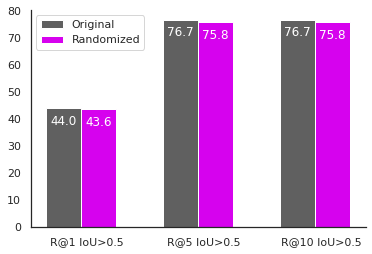

In [10]:
# The performances of the 2D-TAN model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
plt.figure(figsize=(6, 4))
c = ["#606060", "#d602ee"]
labels = ["Original", "Randomized"]
keys = [f"R@{k} IoU>0.5" for k in [1, 5, 10]]
x = np.arange(3)+0.2
for score_summary in [summary, randomized_summary]:
    vals = [score_summary[k] * 100 for k in keys]
    bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=labels.pop(0))
    for b in bars:
        display_score(b, color="w")
    x += 0.3
    
plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    
plt.legend()
sns.despine(left=False)

Text(0.5, 1.0, 'Randomized video input')

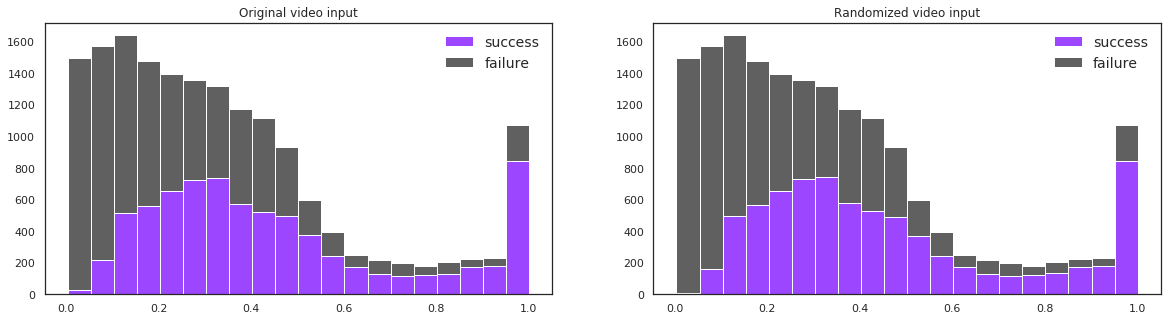

In [14]:
# Check relation between success rates and iput video durations
f, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.rcParams.update({'font.size': 14})
_ = plot_performance_per_duration(results, test_data, ax=axes[0])
axes[0].set_title("Original video input")
_ = plot_performance_per_duration(randomized_results, test_data, ax=axes[1])
axes[1].set_title("Randomized video input")